In [1]:
# imports
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
visited_color = .8
current_color = .5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

actions = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down'
}

num_actions = len(actions)

epsilon = .15

In [3]:
class Maze(object):
    def __init__(self, maze, curr=(0,0)) -> None:
        self._maze = np.array(maze)
        num_rows, num_cols = self._maze.shape
        self.target = (num_rows - 1, num_cols - 1) # end goal

        free_cells = []
        for r in range(num_rows):
            for c in range(num_cols):
                if self._maze[r,c] == 1:
                    free_cells.append((r,c))
        free_cells.remove(self.target)
        self.reset(curr)
    
    def reset(self, curr):
        self.curr = curr
        # use a copy of original maze
        self.maze = np.copy(self._maze)
        num_rows, num_cols = self._maze.shape
        row, col = curr
        self.maze[row, col] = current_color
        self.state = (row, col, 'start')
        self.min_reward = -.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        num_rows, num_cols = self._maze.shape
        nrow, ncol, nmode = curr_row, curr_col, mode = self.state
        
        if self.maze[curr_row, curr_col] > 0:
            self.visited.add((curr_row,curr_col))
        
        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # set new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        curr_row, curr_col, mode = self.state
        nrows, ncols = self.maze.shape
        if curr_row == nrows - 1 and curr_col == ncols - 1:
            return 1
        if mode == 'blocked':
            return self.min_reward - 1
        if (curr_row, curr_col) in self.visited:
            return -.25
        if mode == 'invalid':
            return -.75
        if mode == 'valid':
            return -.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the person
        row, col, valid = self.state
        canvas[row, col] = current_color
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'
    
    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape

        # check if cant move up
        if row == 0 or (row > 0 and self.maze[row - 1, col] == 0):
            actions.remove(1)

        # check if cant move down
        if row == nrows - 1 or (row < nrows - 1 and self.maze[row + 1, col] == 0):
            actions.remove(3)

        # check if cant move left
        if col == 0 or (col > 0 and self.maze[row, col - 1] == 0):
            actions.remove(0)

        # check if cant move right
        if col == ncols - 1 or (col<ncols - 1 and self.maze[row, col + 1] == 0):
            actions.remove(2)

        return actions
        
    

In [4]:
def show(maze):
    plt.grid('on')
    nrows, ncols = maze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(maze.maze)
    for row,col in maze.visited:
        canvas[row,col] = 0.6
    curr_row, curr_col, _ = maze.state
    canvas[curr_row, curr_col] = 0.3   # current cell
    canvas[nrows-1, ncols-1] = 0.9 # target cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

reward= -0.04


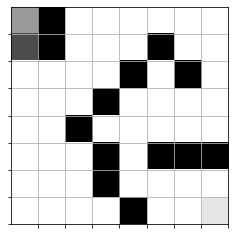

In [5]:
maze = [
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
]

maze = Maze(maze)
canvas, reward, game_over = maze.act(DOWN)
print("reward=", reward)
show(maze)

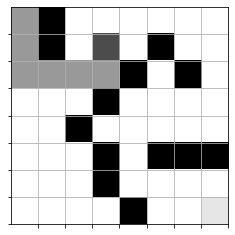

In [7]:
maze.act(DOWN)  # move down
maze.act(RIGHT)  # move right
maze.act(RIGHT)  # move right
maze.act(RIGHT)  # move right
maze.act(UP)  # move up
show(maze)

In [ ]:
def play_game(model, maze, curr_cell):
    maze.reset(curr_cell)
    envstate = maze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = maze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [ ]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True